In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests
from scipy.stats import chi2_contingency


from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [2]:
raw_df = pd.read_csv('../data/f1_agg_mean_v2.csv')
raw_df

features = [
    'mean_0',
    'std_0',
    'dwell_0',
    'mean_1',
    'std_1',
    'dwell_1',
    'mean_2',
    'std_2',
    'dwell_2'
]

# 1. Explore original features

## a. EDA

In [3]:
raw_df_p = raw_df.melt(
    id_vars='label',
    value_vars=features,
    var_name='feature',
    value_name='value'
)

raw_df_p

,label,feature,value
0,0,mean_0,0.008264
1,0,mean_0,0.006609
2,0,mean_0,0.007570
3,0,mean_0,0.010620
4,0,mean_0,0.010701
...,...,...,...
1096537,1,dwell_2,82.004110
1096538,0,dwell_2,80.497101
1096539,1,dwell_2,84.190625
1096540,0,dwell_2,82.289474


### Original PCA Plot

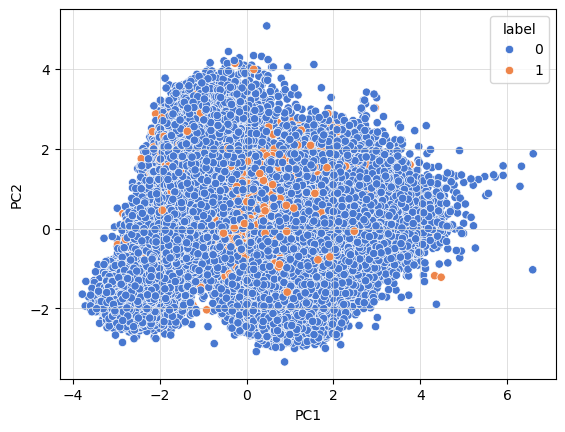

In [4]:
X = raw_df.drop(columns=['transcript_id', 'transcript_position', 'sequence', 'gene_id', 'label'])
y = raw_df['label']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)
pca_data = pca.fit_transform(X_scaled)

pca_df = pd.DataFrame(data=pca_data, columns=['PC1', 'PC2'])
pca_df['label'] = y


sns.scatterplot(pca_df, x='PC1', y='PC2', hue='label', palette='muted')
plt.grid(color='lightgray', linewidth=0.5)
plt.show()

### Boxplots

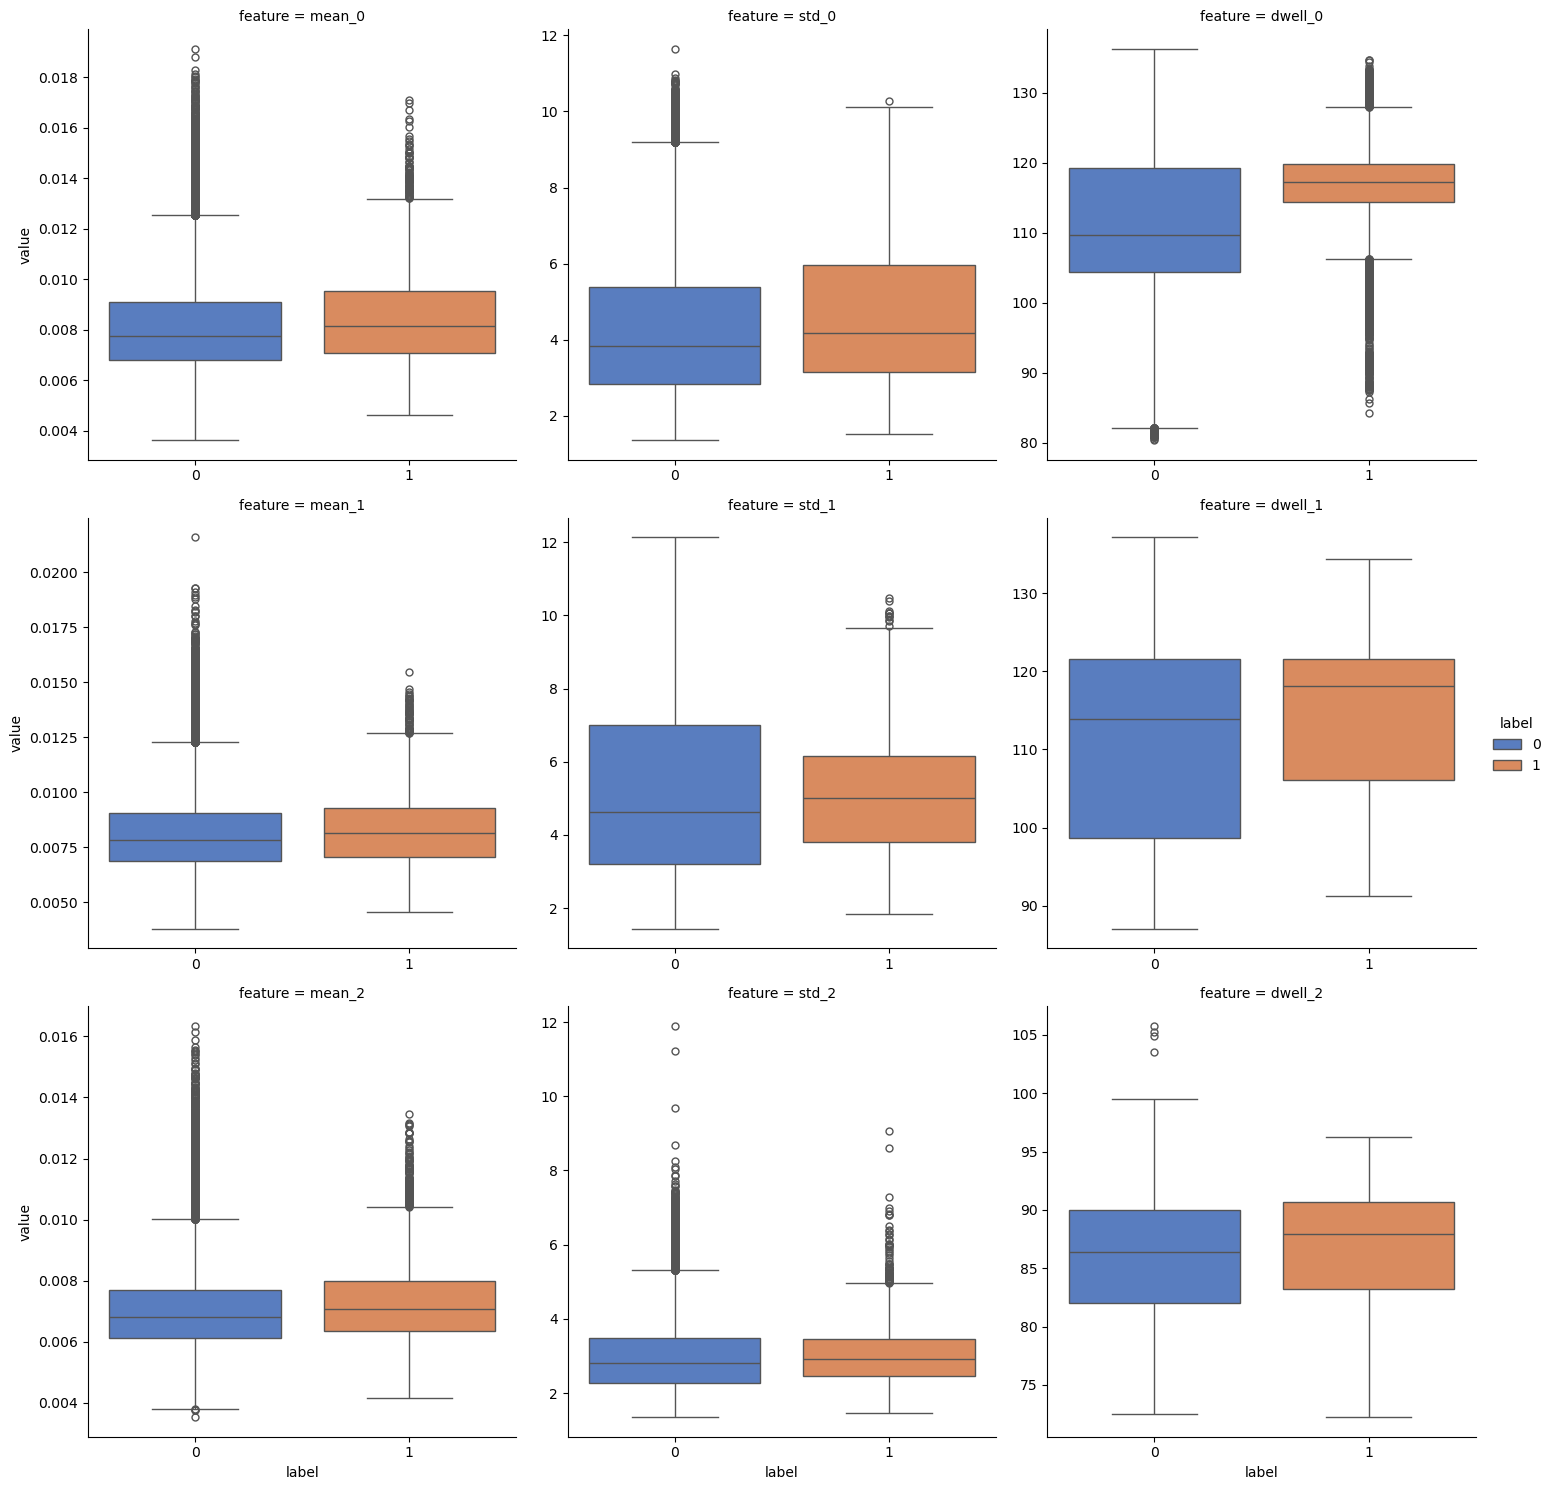

In [5]:
g = sns.catplot(
    data=raw_df_p,
    x='label',
    y='value',
    hue='label',
    col='feature',
    col_wrap=3,       
    kind='box',
    palette='muted',
    sharex=False, sharey=False
)


plt.show()

### Histograms

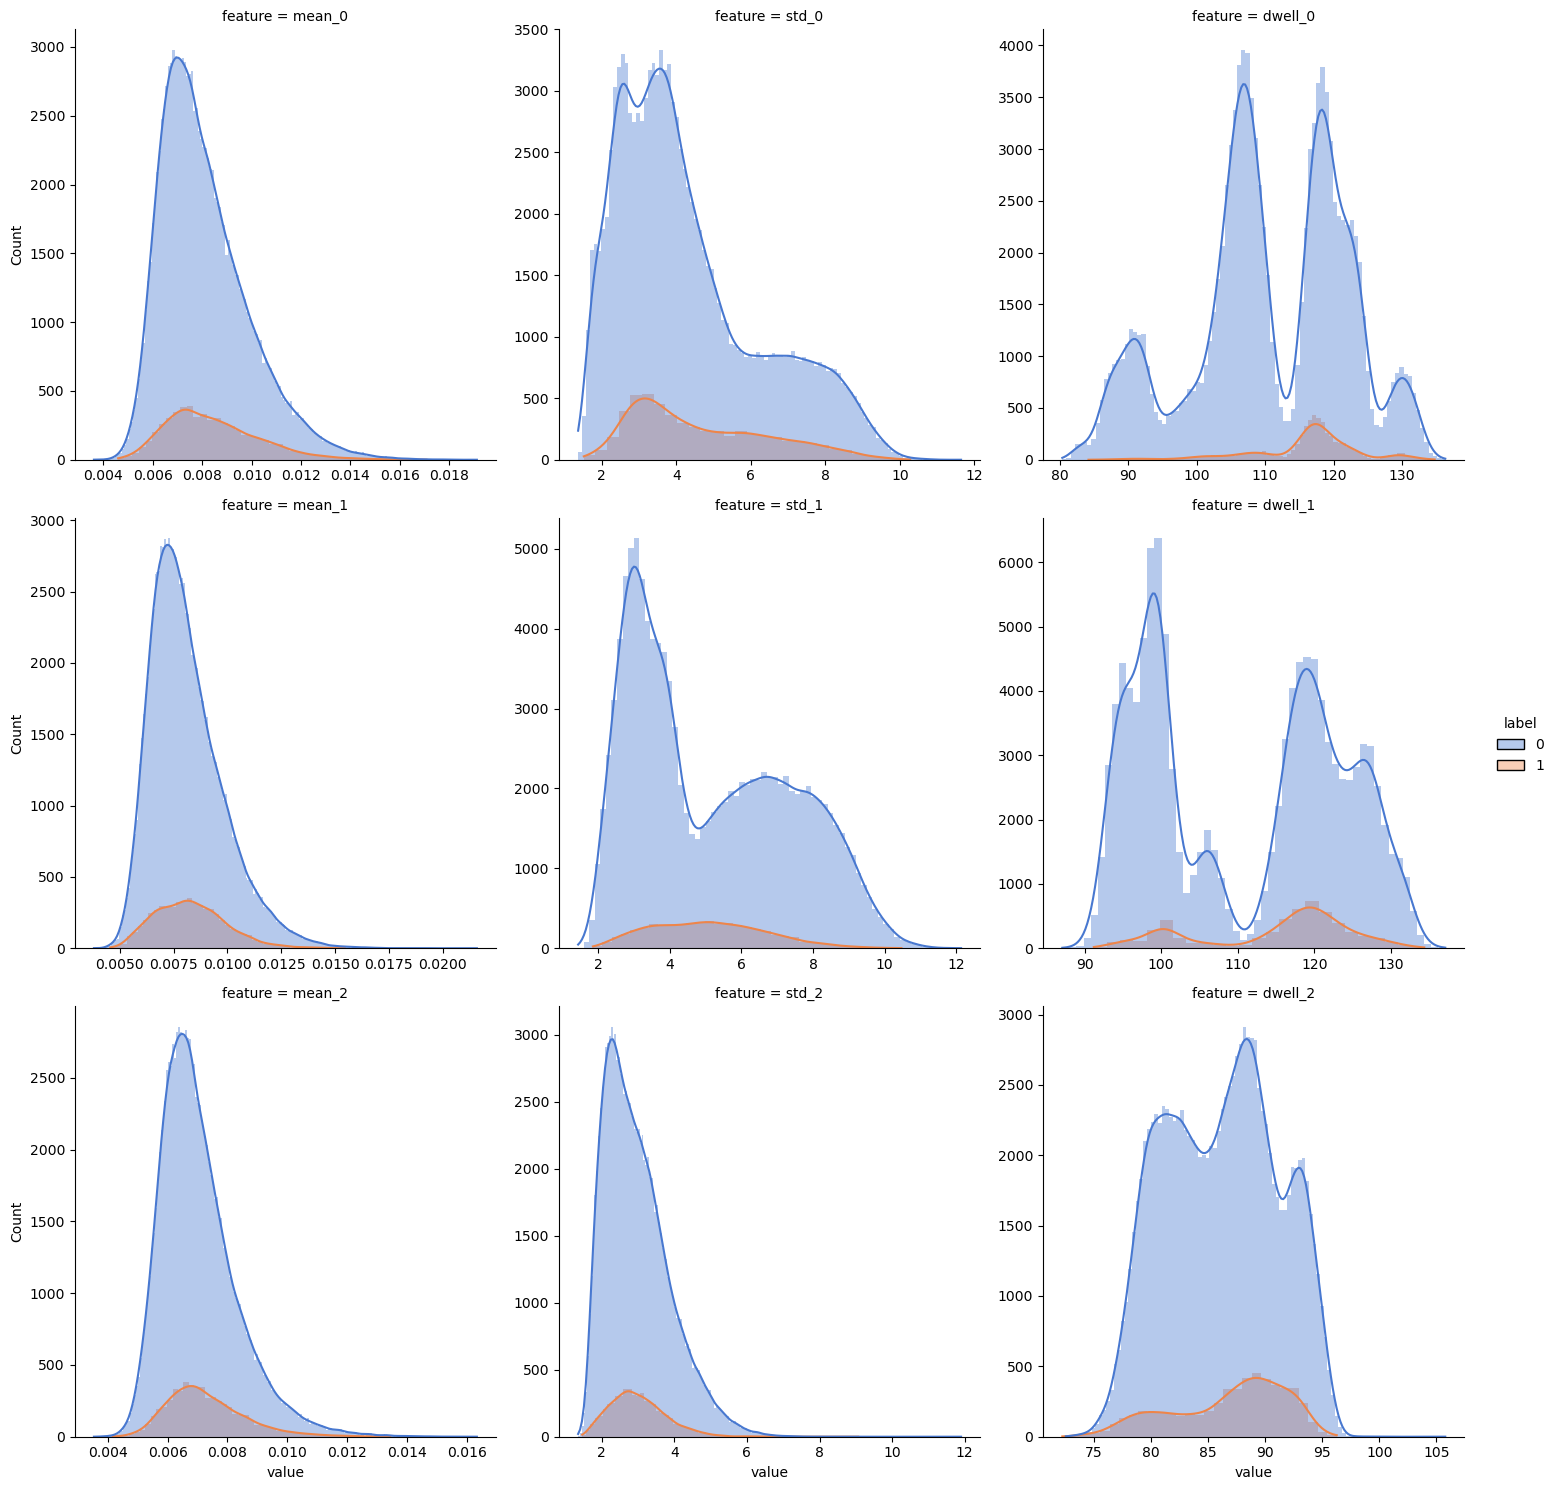

In [6]:
g = sns.displot(
    data=raw_df_p,
    x='value',
    hue='label',
    col='feature',
    col_wrap=3, 
    kind='hist',
    palette='muted',
    kde=True,
    alpha=0.4, 
    facet_kws=dict(sharex=False, sharey=False),
    common_bins = False
)

plt.show()

## b. Data Transformation

### Removing Skewness for numerical features

In [7]:
# Check for columns with zero
zero_cols = raw_df[features].loc[:, (raw_df == 0).any()].select_dtypes(include=['number']).columns
print(f'Features with zero values: {zero_cols}') # no columns with zero values

# Check skewness for numerical features
feat_skewness = raw_df[features].skew().sort_values(ascending=False) 
skewed_feats = feat_skewness[abs(feat_skewness) >= 0.4]
print('\n Initial Skewness: ')
display(skewed_feats)


skewed_cols = skewed_feats.index

ns_cols = []

test_skew_df = raw_df.copy()

for col in skewed_cols:
    log_col = "log_" + col
    ns_cols.append(log_col)

    # Perform log transformation
    test_skew_df[log_col] = np.log(test_skew_df[col])

    # Perform box-cox transformation
    bc_col = "bc_" + col
    ns_cols.append(bc_col)
    
    test_skew_df[bc_col], _ = stats.boxcox(test_skew_df[col])

print('\n Removed Skewness: ')
check_skewness = test_skew_df[ns_cols].skew()
check_skewness

Features with zero values: Index([], dtype='object')

 Initial Skewness: 


mean_2    1.164426
mean_0    0.996194
mean_1    0.969962
std_2     0.935588
std_0     0.841961
std_1     0.437824
dtype: float64


 Removed Skewness: 


log_mean_2    0.543146
bc_mean_2     0.002036
log_mean_0    0.406398
bc_mean_0     0.016581
log_mean_1    0.371416
bc_mean_1     0.009777
log_std_2     0.241643
bc_std_2      0.021538
log_std_0     0.099744
bc_std_0      0.011892
log_std_1    -0.058040
bc_std_1     -0.014733
dtype: float64

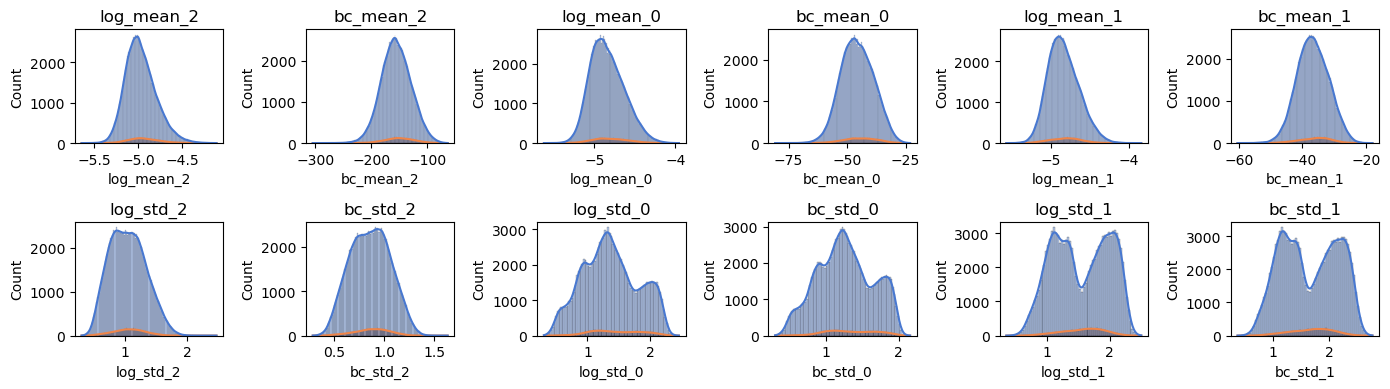

,transcript_id,transcript_position,sequence,mean_0,std_0,dwell_0,mean_1,std_1,dwell_1,mean_2,std_2,dwell_2,gene_id,label,log_mean_2,log_mean_0,log_mean_1,log_std_2,log_std_0,log_std_1
0,ENST00000000233,244,AAGACCA,0.008264,4.223784,123.702703,0.009373,7.382162,125.913514,0.007345,4.386989,80.570270,ENSG00000004059,0,-4.913747,-4.795801,-4.669896,1.478643,1.440731,1.999067
1,ENST00000000233,261,CAAACTG,0.006609,3.216424,109.681395,0.006813,3.226535,107.889535,0.007710,3.016599,94.290698,ENSG00000004059,0,-4.865199,-5.019286,-4.988936,1.104130,1.168270,1.171409
2,ENST00000000233,316,GAAACAG,0.007570,2.940541,105.475676,0.007416,3.642703,98.947027,0.007555,2.087146,89.364324,ENSG00000004059,0,-4.885521,-4.883562,-4.904181,0.735798,1.078593,1.292726
3,ENST00000000233,332,AGAACAT,0.010620,6.476350,129.355000,0.008632,2.899200,97.836500,0.006101,2.236520,89.154000,ENSG00000004059,0,-5.099221,-4.544993,-4.752244,0.804921,1.868157,1.064435
4,ENST00000000233,368,AGGACAA,0.010701,6.415051,117.924242,0.011479,5.870303,121.954545,0.010019,4.260253,85.178788,ENSG00000004059,0,-4.603273,-4.537464,-4.467215,1.449328,1.858647,1.769906
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121833,ENST00000641834,1348,GGGACAT,0.009594,3.294164,118.232877,0.007300,4.929726,116.342466,0.006555,4.005616,82.004110,ENSG00000167747,1,-5.027600,-4.646635,-4.919937,1.387697,1.192153,1.595283
121834,ENST00000641834,1429,CTGACAC,0.008393,4.511014,110.969565,0.010305,9.105797,114.927536,0.005568,3.644638,80.497101,ENSG00000167747,0,-5.190803,-4.780387,-4.575105,1.293257,1.506522,2.208911
121835,ENST00000641834,1531,TGGACAC,0.008161,3.918438,113.968750,0.006877,4.759688,113.562500,0.006410,2.181563,84.190625,ENSG00000167747,1,-5.049920,-4.808435,-4.979614,0.780041,1.365693,1.560182
121836,ENST00000641834,1537,CTGACCA,0.008044,3.191228,109.354386,0.007419,6.552982,123.263158,0.006472,2.540877,82.289474,ENSG00000167747,0,-5.040254,-4.822846,-4.903647,0.932509,1.160406,1.879920


In [ ]:
fig, axes = plt.subplots(2, 6, figsize=(14, 4))
axes = axes.flatten()

for i, feature in enumerate(ns_cols):
    sns.histplot(data=test_skew_df, x=feature, hue='label',
                ax=axes[i], palette='muted',
                 kde=True, alpha=0.4
    )
    axes[i].set_title(feature)

# Remove individual legends
for ax in axes:
    ax.legend_.remove() if ax.get_legend() else None

# # Add one shared legend (from the first plot)
# handles, labels = axes[0].get_legend_handles_labels()
# fig.legend(handles, labels, title="Label", loc='upper right', bbox_to_anchor=(1.05, 1))

plt.tight_layout()
plt.show()

# Box-cox transformation results in large values, to drop box-cox transformation
bc_cols = [
    'bc_mean_0',
    'bc_mean_1',
    'bc_mean_2',
    'bc_std_0',
    'bc_std_1',
    'bc_std_2'
]

no_skew_df = test_skew_df.copy().drop(columns=bc_cols)
no_skew_df

In [ ]:
# save one version for the reducedskew cols
drop_cols = [
    'mean_0',
    'mean_1',
    'mean_2',
    'std_0',
    'std_1',
    'std_2'
]

test_2_df = no_skew_df.drop(columns=drop_cols)
test_2_df.to_csv('../data/int/f2_reduce_skew.csv', index=False) # save as intermediate df, reduced skewness only

### One-hot encoding for 'sequence'

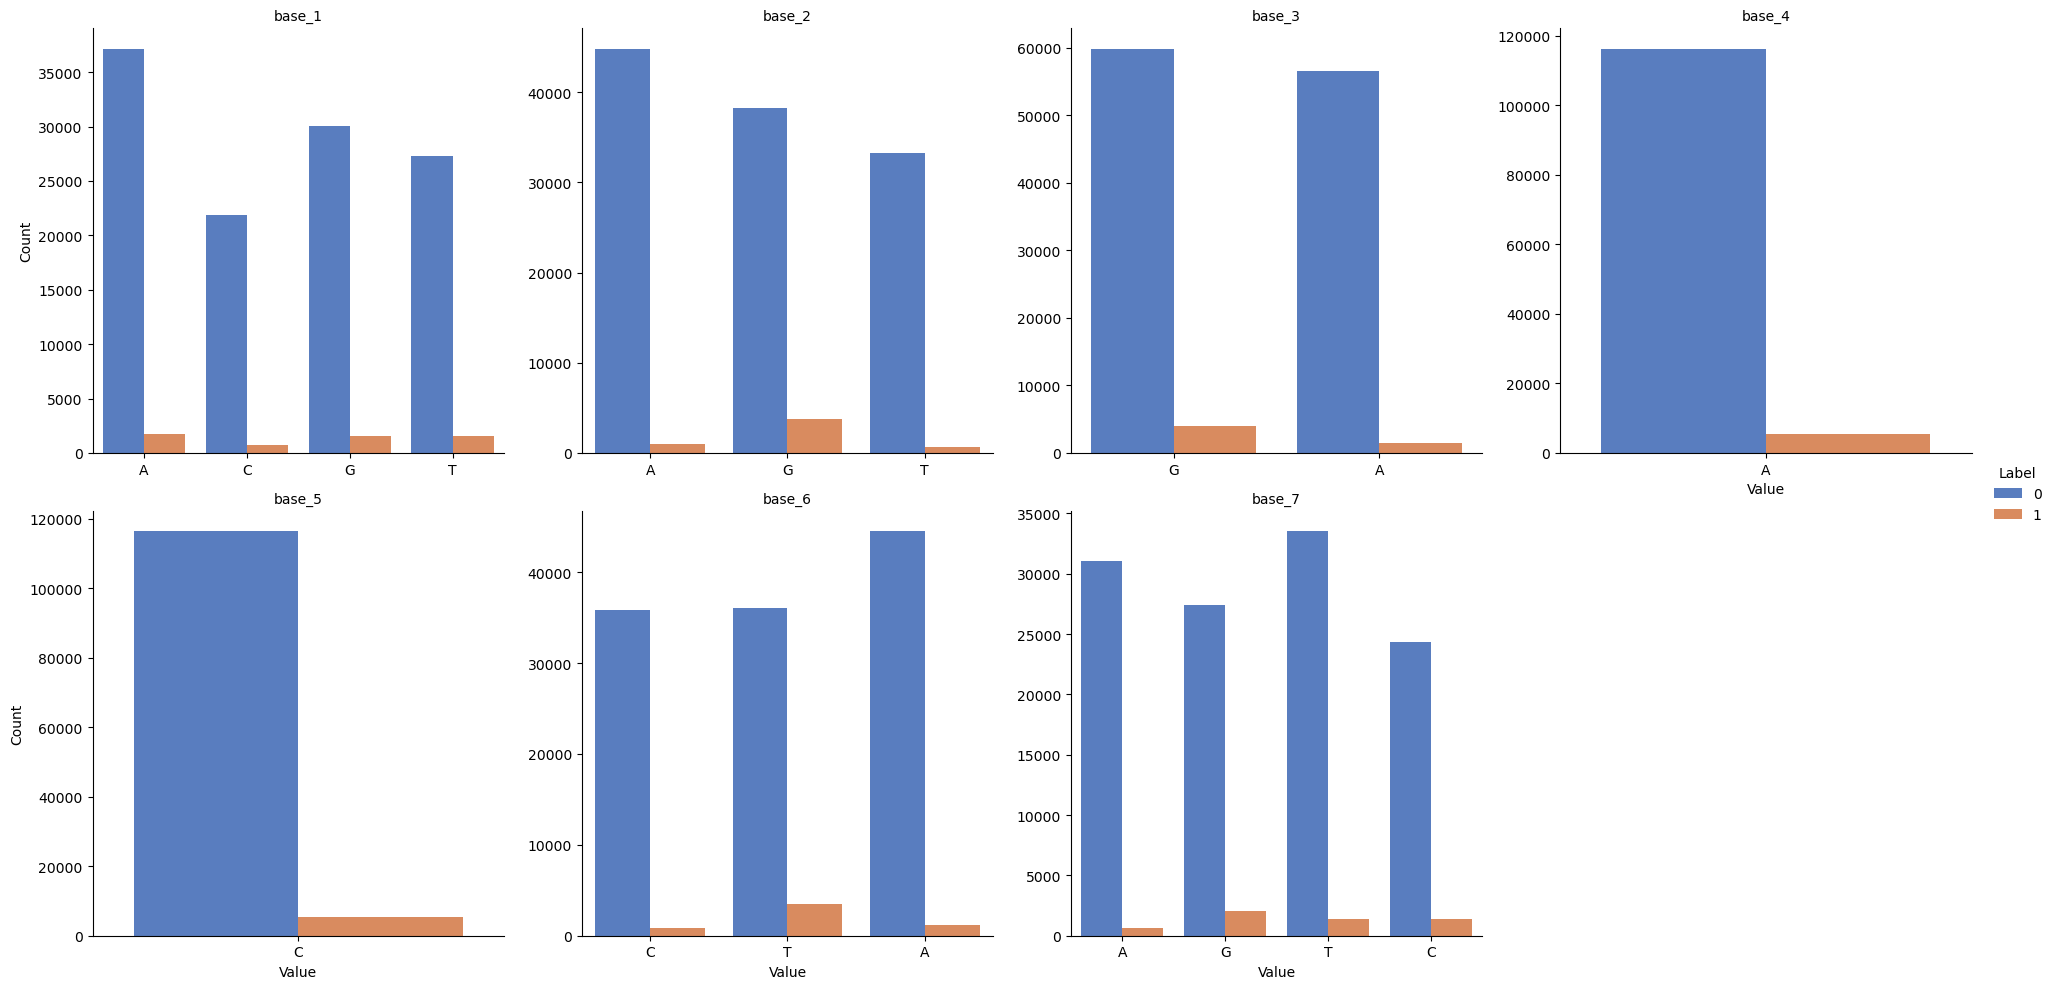

In [42]:
examine_seq_df = test_2_df.copy()

seq_list = examine_seq_df['sequence'].apply(lambda x: list(x))
seq_expanded = pd.DataFrame(seq_list.tolist(), columns=[f"base_{i+1}" for i in range(seq_list.str.len().max())])
base_cols = seq_expanded.columns.to_list()

examine_seq_df = examine_seq_df.join(seq_expanded)
    
examine_seq_df_p = examine_seq_df.melt(
    id_vars='label', 
    value_vars=base_cols, 
    var_name='feature', 
    value_name='value'
)

# Create the catplot
g = sns.catplot(
    data=examine_seq_df_p,
    x='value',
    hue='label',
    col='feature',
    col_wrap=4,   
    kind='count',
    palette='muted',
    sharey=False, sharex=False
)

# Adjust the plot
g.set_titles("{col_name}") 
g.set_axis_labels("Value", "Count")  
g._legend.set_title("Label") 

plt.show()

In [11]:
# 18 additional columns after one hot encoding
seq_encode_df = pd.get_dummies(examine_seq_df, columns=base_cols, dtype=int)

# drop base_4 and base_5 since there's only one possible value
seq_encode_df.drop(columns=['base_4_A', 'base_5_C', 'sequence'])

,transcript_id,transcript_position,dwell_0,dwell_1,dwell_2,gene_id,label,log_mean_2,log_mean_0,log_mean_1,...,base_2_T,base_3_A,base_3_G,base_6_A,base_6_C,base_6_T,base_7_A,base_7_C,base_7_G,base_7_T
0,ENST00000000233,244,123.702703,125.913514,80.570270,ENSG00000004059,0,-4.913747,-4.795801,-4.669896,...,0,0,1,0,1,0,1,0,0,0
1,ENST00000000233,261,109.681395,107.889535,94.290698,ENSG00000004059,0,-4.865199,-5.019286,-4.988936,...,0,1,0,0,0,1,0,0,1,0
2,ENST00000000233,316,105.475676,98.947027,89.364324,ENSG00000004059,0,-4.885521,-4.883562,-4.904181,...,0,1,0,1,0,0,0,0,1,0
3,ENST00000000233,332,129.355000,97.836500,89.154000,ENSG00000004059,0,-5.099221,-4.544993,-4.752244,...,0,1,0,1,0,0,0,0,0,1
4,ENST00000000233,368,117.924242,121.954545,85.178788,ENSG00000004059,0,-4.603273,-4.537464,-4.467215,...,0,0,1,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121833,ENST00000641834,1348,118.232877,116.342466,82.004110,ENSG00000167747,1,-5.027600,-4.646635,-4.919937,...,0,0,1,1,0,0,0,0,0,1
121834,ENST00000641834,1429,110.969565,114.927536,80.497101,ENSG00000167747,0,-5.190803,-4.780387,-4.575105,...,1,0,1,1,0,0,0,1,0,0
121835,ENST00000641834,1531,113.968750,113.562500,84.190625,ENSG00000167747,1,-5.049920,-4.808435,-4.979614,...,0,0,1,1,0,0,0,1,0,0
121836,ENST00000641834,1537,109.354386,123.263158,82.289474,ENSG00000167747,0,-5.040254,-4.822846,-4.903647,...,1,0,1,0,1,0,1,0,0,0


### 2nd Checkpoint
* Prepare 2nd feature set

In [12]:
seq_encode_df = seq_encode_df[[
    'transcript_id',
    'transcript_position',
    'gene_id',
    'dwell_0',
    'dwell_1',
    'dwell_2',
    'log_mean_0',
    'log_mean_1',
    'log_mean_2',
    'log_std_0',
    'log_std_1',
    'log_std_2',
    'base_1_A','base_1_C', 'base_1_G', 'base_1_T', 
    'base_2_A', 'base_2_G', 'base_2_T',
    'base_3_A', 'base_3_G', 
    'base_6_A', 'base_6_C', 'base_6_T', 
    'base_7_A', 'base_7_C', 'base_7_G', 'base_7_T',
    'label'
]]

print(examine_seq_df.shape)
print(examine_seq_df.columns)
print(seq_encode_df.shape)
print(seq_encode_df.columns)

# save as feature set 2
display(seq_encode_df)

seq_encode_df.to_csv('../data/f2_noskew_ohe.csv', index=False)

(121838, 21)
Index(['transcript_id', 'transcript_position', 'sequence', 'dwell_0',
       'dwell_1', 'dwell_2', 'gene_id', 'label', 'log_mean_2', 'log_mean_0',
       'log_mean_1', 'log_std_2', 'log_std_0', 'log_std_1', 'base_1', 'base_2',
       'base_3', 'base_4', 'base_5', 'base_6', 'base_7'],
      dtype='object')
(121838, 29)
Index(['transcript_id', 'transcript_position', 'gene_id', 'dwell_0', 'dwell_1',
       'dwell_2', 'log_mean_0', 'log_mean_1', 'log_mean_2', 'log_std_0',
       'log_std_1', 'log_std_2', 'base_1_A', 'base_1_C', 'base_1_G',
       'base_1_T', 'base_2_A', 'base_2_G', 'base_2_T', 'base_3_A', 'base_3_G',
       'base_6_A', 'base_6_C', 'base_6_T', 'base_7_A', 'base_7_C', 'base_7_G',
       'base_7_T', 'label'],
      dtype='object')


,transcript_id,transcript_position,gene_id,dwell_0,dwell_1,dwell_2,log_mean_0,log_mean_1,log_mean_2,log_std_0,...,base_3_A,base_3_G,base_6_A,base_6_C,base_6_T,base_7_A,base_7_C,base_7_G,base_7_T,label
0,ENST00000000233,244,ENSG00000004059,123.702703,125.913514,80.570270,-4.795801,-4.669896,-4.913747,1.440731,...,0,1,0,1,0,1,0,0,0,0
1,ENST00000000233,261,ENSG00000004059,109.681395,107.889535,94.290698,-5.019286,-4.988936,-4.865199,1.168270,...,1,0,0,0,1,0,0,1,0,0
2,ENST00000000233,316,ENSG00000004059,105.475676,98.947027,89.364324,-4.883562,-4.904181,-4.885521,1.078593,...,1,0,1,0,0,0,0,1,0,0
3,ENST00000000233,332,ENSG00000004059,129.355000,97.836500,89.154000,-4.544993,-4.752244,-5.099221,1.868157,...,1,0,1,0,0,0,0,0,1,0
4,ENST00000000233,368,ENSG00000004059,117.924242,121.954545,85.178788,-4.537464,-4.467215,-4.603273,1.858647,...,0,1,1,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121833,ENST00000641834,1348,ENSG00000167747,118.232877,116.342466,82.004110,-4.646635,-4.919937,-5.027600,1.192153,...,0,1,1,0,0,0,0,0,1,1
121834,ENST00000641834,1429,ENSG00000167747,110.969565,114.927536,80.497101,-4.780387,-4.575105,-5.190803,1.506522,...,0,1,1,0,0,0,1,0,0,0
121835,ENST00000641834,1531,ENSG00000167747,113.968750,113.562500,84.190625,-4.808435,-4.979614,-5.049920,1.365693,...,0,1,1,0,0,0,1,0,0,1
121836,ENST00000641834,1537,ENSG00000167747,109.354386,123.263158,82.289474,-4.822846,-4.903647,-5.040254,1.160406,...,0,1,0,1,0,1,0,0,0,0


### PCA Plot
* Check separation after some feature engineering

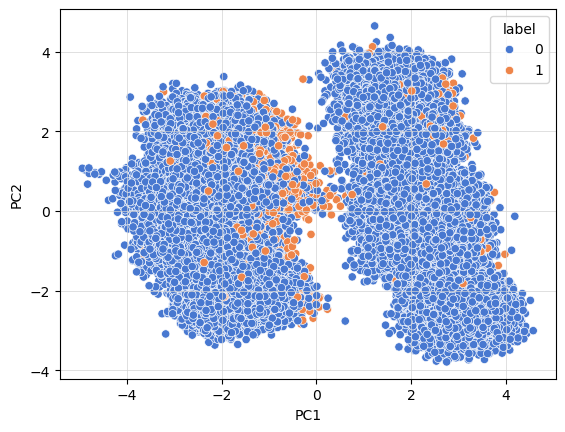

In [13]:
X = seq_encode_df.drop(columns=['transcript_id', 'transcript_position','gene_id', 'label'])
y = seq_encode_df['label']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)
pca_data = pca.fit_transform(X_scaled)

pca_df = pd.DataFrame(data=pca_data, columns=['PC1', 'PC2'])
pca_df['label'] = y


sns.scatterplot(pca_df, x='PC1', y='PC2', hue='label', palette='muted')
plt.grid(color='lightgray', linewidth=0.5)
plt.show()

* Check feature contribution to PCA explained variance

In [14]:
# component_weights = pca.components_

# pca_cols = seq_encode_df.columns.drop(['transcript_id', 'transcript_position',  'gene_id', 'label'])

# feature_weights_mapping = {}
# for i, component in enumerate(component_weights):
#   component_feature_weights = zip(pca_cols, component)
#   sorted_feature_weight = sorted(
#       component_feature_weights, key=lambda x: abs(x[1]), reverse=True)
#   feature_weights_mapping[f"Component {i+1}"] = sorted_feature_weight

# pca_exp_var = pd.DataFrame(feature_weights_mapping)
# pca_exp_var

### Feature Scaling

In [ ]:
# to check

### Statistical Testing

In [16]:
new_num_features = [
    'dwell_0',
    'dwell_1',
    'dwell_2',
    'log_mean_0',
    'log_mean_1',
    'log_mean_2',
    'log_std_0',
    'log_std_1',
    'log_std_2'
]

#### Numerical Columns

In [17]:
num_stats_res = []

for feat in new_num_features:
    g1 = seq_encode_df.loc[seq_encode_df['label'] == 1, feat]
    g0 = seq_encode_df.loc[seq_encode_df['label'] == 0, feat]
    stat, p = mannwhitneyu(g1, g0, alternative='two-sided')
    r = 1 - (2 * stat) / (len(g1) * len(g0))
    num_stats_res.append({'feature': feat, 'p_value': p, 'effect_size_r': abs(r)})

num_stats_res_df = pd.DataFrame(num_stats_res).sort_values('p_value')
num_stats_res_df['p_adj'] = multipletests(num_stats_res_df['p_value'], method='fdr_bh')[1]

num_stats_res_df['p_value_str'] = num_stats_res_df['p_value'].apply(lambda x: f"{x:.20f}")
num_stats_res_df['p_adj_str'] = num_stats_res_df['p_adj'].apply(lambda x: f"{x:.20f}")

num_stats_res_df[['feature', 'p_value_str', 'p_adj_str', 'effect_size_r']]

,feature,p_value_str,p_adj_str,effect_size_r
0,dwell_0,0.00000000000000000000,0.00000000000000000000,0.267720
1,dwell_1,0.00000000000000000000,0.00000000000000000000,0.176320
5,log_mean_2,0.00000000000000000000,0.00000000000000000000,0.121533
6,log_std_0,0.00000000000000000000,0.00000000000000000000,0.118721
3,log_mean_0,0.00000000000000000000,0.00000000000000000000,0.106938
2,dwell_2,0.00000000000000000000,0.00000000000000000000,0.090940
4,log_mean_1,0.00000000000000000000,0.00000000000000000000,0.078607
8,log_std_2,0.00000000000053397364,0.00000000000060072034,0.057617
7,log_std_1,0.00099440023053860784,0.00099440023053860784,0.026285


# 2. Explore New Features

In [19]:
# Add back the original features (mean and std)
add_cols = no_skew_df[[
    'mean_0',
    'std_0',
    'mean_1',
    'std_1',
    'mean_2',
    'std_2'
]]

new_feat_df = seq_encode_df.copy()
new_feat_df = pd.concat([new_feat_df, add_cols], axis=1)
new_feat_df

,transcript_id,transcript_position,gene_id,dwell_0,dwell_1,dwell_2,log_mean_0,log_mean_1,log_mean_2,log_std_0,...,base_7_C,base_7_G,base_7_T,label,mean_0,std_0,mean_1,std_1,mean_2,std_2
0,ENST00000000233,244,ENSG00000004059,123.702703,125.913514,80.570270,-4.795801,-4.669896,-4.913747,1.440731,...,0,0,0,0,0.008264,4.223784,0.009373,7.382162,0.007345,4.386989
1,ENST00000000233,261,ENSG00000004059,109.681395,107.889535,94.290698,-5.019286,-4.988936,-4.865199,1.168270,...,0,1,0,0,0.006609,3.216424,0.006813,3.226535,0.007710,3.016599
2,ENST00000000233,316,ENSG00000004059,105.475676,98.947027,89.364324,-4.883562,-4.904181,-4.885521,1.078593,...,0,1,0,0,0.007570,2.940541,0.007416,3.642703,0.007555,2.087146
3,ENST00000000233,332,ENSG00000004059,129.355000,97.836500,89.154000,-4.544993,-4.752244,-5.099221,1.868157,...,0,0,1,0,0.010620,6.476350,0.008632,2.899200,0.006101,2.236520
4,ENST00000000233,368,ENSG00000004059,117.924242,121.954545,85.178788,-4.537464,-4.467215,-4.603273,1.858647,...,0,0,0,0,0.010701,6.415051,0.011479,5.870303,0.010019,4.260253
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121833,ENST00000641834,1348,ENSG00000167747,118.232877,116.342466,82.004110,-4.646635,-4.919937,-5.027600,1.192153,...,0,0,1,1,0.009594,3.294164,0.007300,4.929726,0.006555,4.005616
121834,ENST00000641834,1429,ENSG00000167747,110.969565,114.927536,80.497101,-4.780387,-4.575105,-5.190803,1.506522,...,1,0,0,0,0.008393,4.511014,0.010305,9.105797,0.005568,3.644638
121835,ENST00000641834,1531,ENSG00000167747,113.968750,113.562500,84.190625,-4.808435,-4.979614,-5.049920,1.365693,...,1,0,0,1,0.008161,3.918438,0.006877,4.759688,0.006410,2.181563
121836,ENST00000641834,1537,ENSG00000167747,109.354386,123.263158,82.289474,-4.822846,-4.903647,-5.040254,1.160406,...,0,0,0,0,0.008044,3.191228,0.007419,6.552982,0.006472,2.540877


In [ ]:
# Explore new features

# Find sum across all 3 positions
new_feat_df['sum_mean'] = new_feat_df[['mean_0', 'mean_1', 'mean_2']].sum(axis=1)
new_feat_df['sum_std'] = new_feat_df[['std_0', 'std_1', 'std_2']].sum(axis=1) # to drop because effect size is small
new_feat_df['sum_dwell'] = new_feat_df[['dwell_0', 'dwell_1', 'dwell_2']].sum(axis=1)

# Find coefficient of variation (variability)
new_feat_df['cv_0'] = new_feat_df['std_0'] / new_feat_df['mean_0']
new_feat_df['cv_1'] = new_feat_df['std_1'] / new_feat_df['mean_1']
new_feat_df['cv_2'] = new_feat_df['std_2'] / new_feat_df['mean_2']

In [22]:
new_feat = [
    'sum_mean',
    'sum_std',
    'sum_dwell',
    'cv_0',
    'cv_1',
    'cv_2',
]


new_feat_df_p = new_feat_df.melt(
    id_vars='label',
    value_vars=new_feat,
    var_name='new_feature',
    value_name='value'
)

new_feat_df_p

,label,new_feature,value
0,0,sum_mean,0.024983
1,0,sum_mean,0.021132
2,0,sum_mean,0.022541
3,0,sum_mean,0.025354
4,0,sum_mean,0.032199
...,...,...,...
731023,1,cv_2,611.122722
731024,0,cv_2,654.623074
731025,1,cv_2,340.345660
731026,0,cv_2,392.588978


### Boxplot for New Features

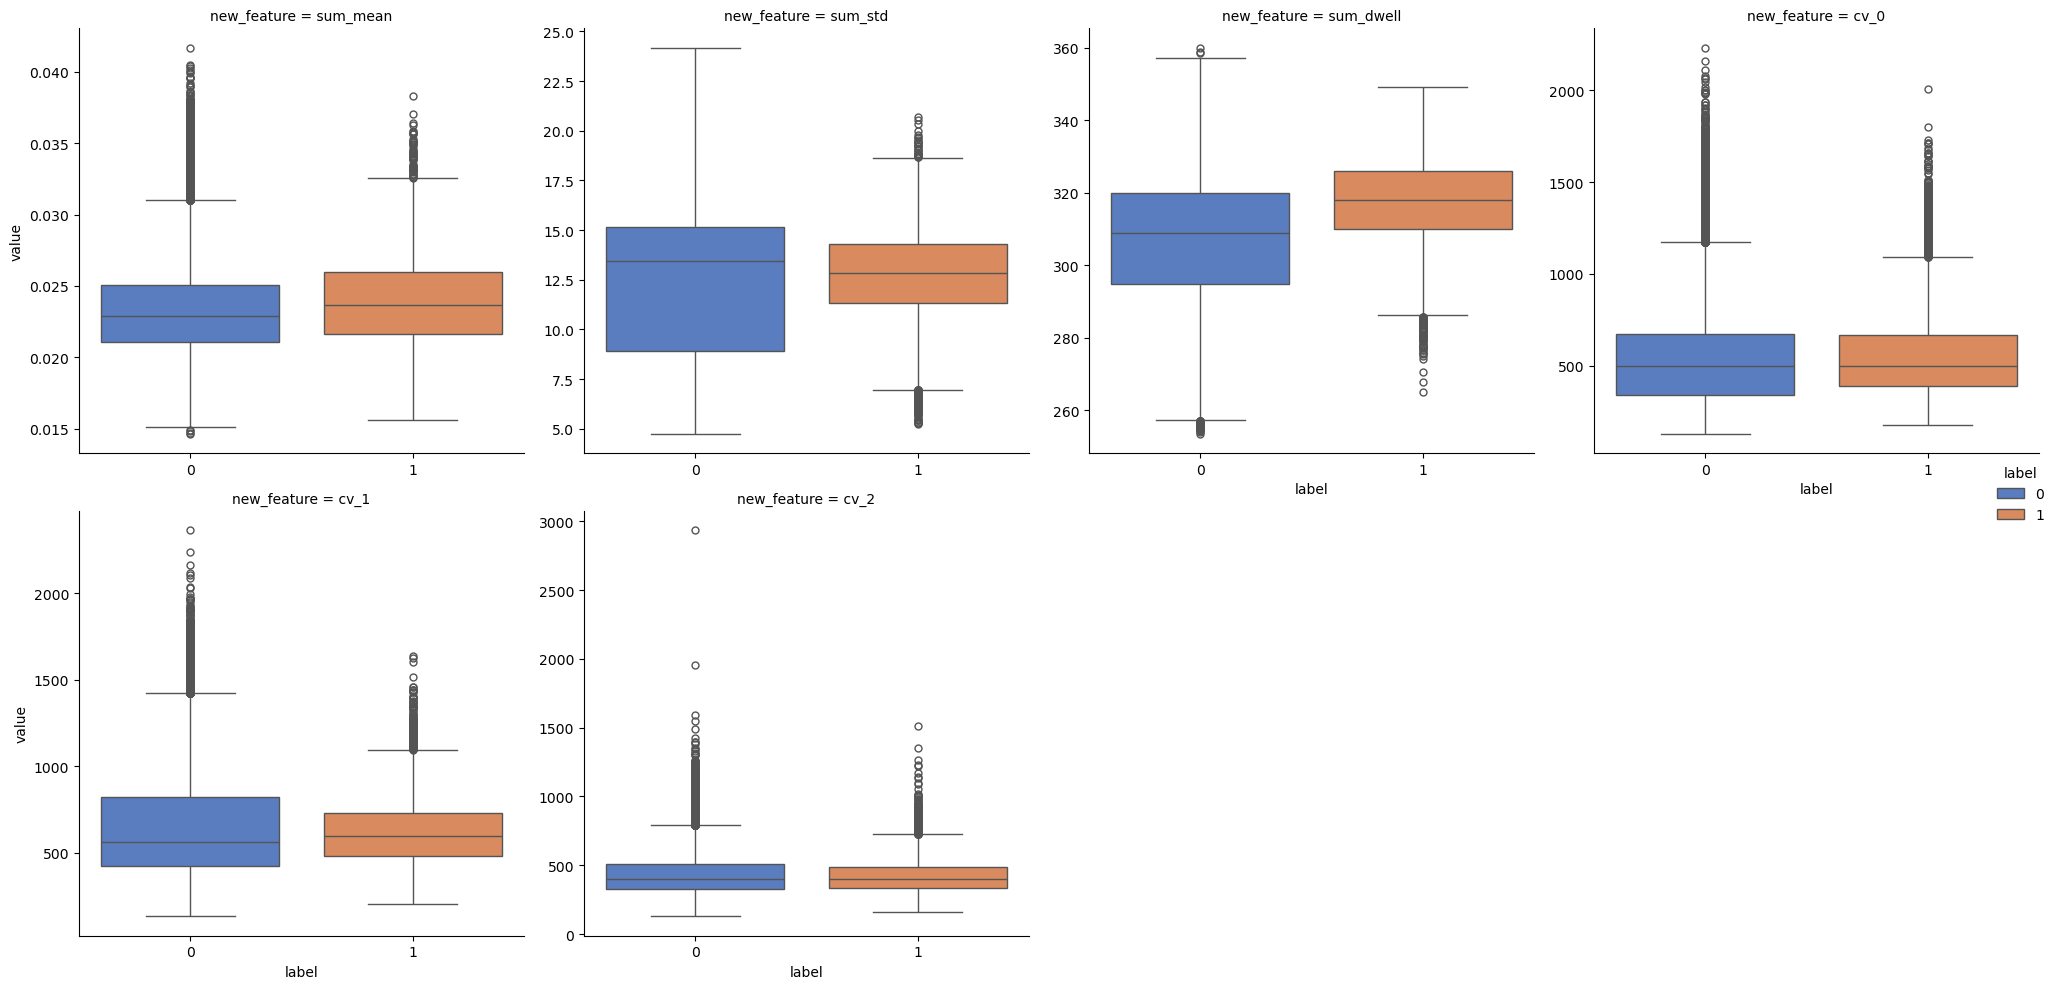

In [23]:
g = sns.catplot(
    data=new_feat_df_p,
    x='label',
    y='value',
    hue='label',
    col='new_feature',
    col_wrap=4,       
    kind='box',
    palette='muted',
    sharex=False, sharey=False
)


plt.tight_layout()
plt.show()

### Histogram for New Features

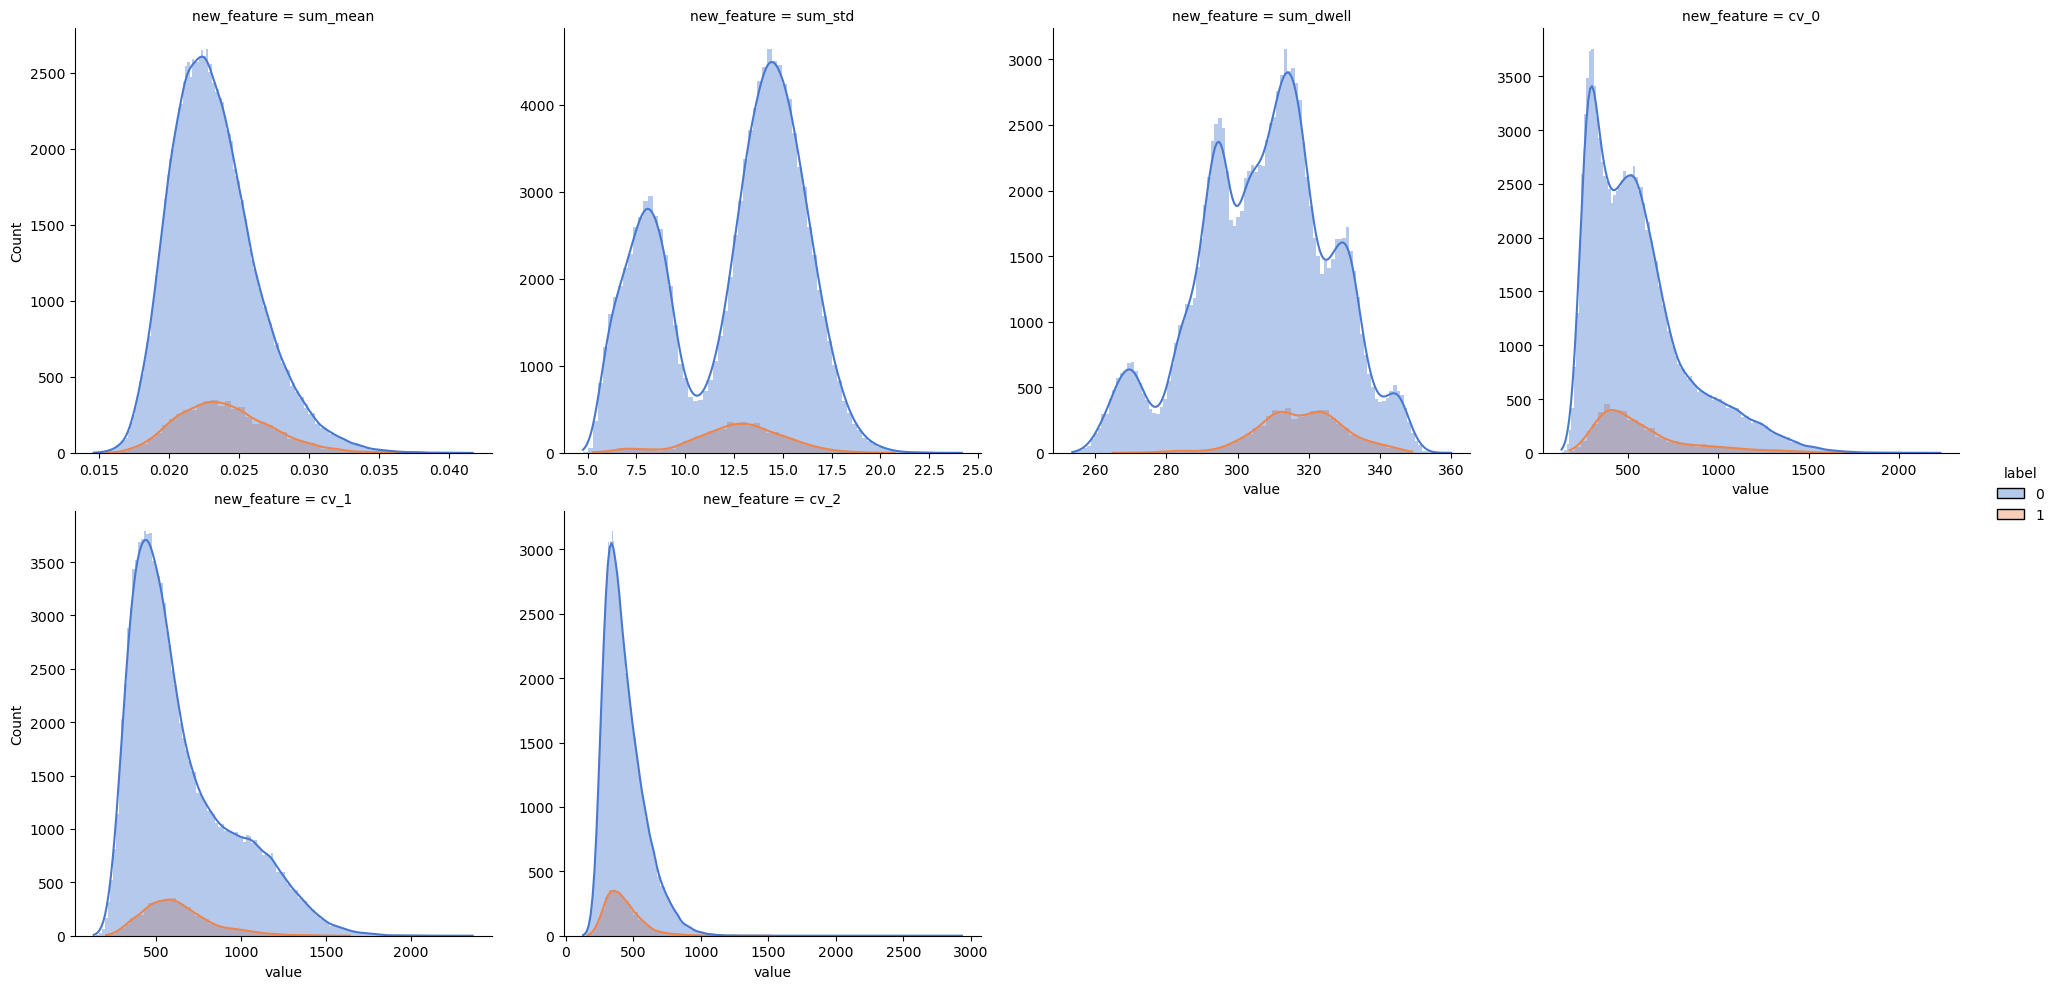

In [24]:
g = sns.displot(
    data=new_feat_df_p,
    x='value',
    hue='label',
    col='new_feature',
    col_wrap=4, 
    kind='hist',
    palette='muted',
    kde=True,
    alpha=0.4, 
    facet_kws=dict(sharex=False, sharey=False),
    common_bins = False
)

plt.show()

### Check Skewness

In [25]:
# Check for columns with zero
zero_cols = new_feat_df[new_feat].loc[:, (new_feat_df == 0).any()].select_dtypes(include=['number']).columns
print(f'Features with zero values: {zero_cols}') # no columns with zero values

# Check skewness for numerical features
feat_skewness = new_feat_df[new_feat].skew().sort_values(ascending=False) 
display(feat_skewness)
skewed_feats = feat_skewness[abs(feat_skewness) >= 1]
print('\n Initial Skewness: ')
display(skewed_feats)


skewed_cols = skewed_feats.index

ns_cols = []

for col in skewed_cols:
    log_col = "log_" + col
    ns_cols.append(log_col)

    # Perform log transformation
    new_feat_df[log_col] = np.log(new_feat_df[col])
    new_feat_df.drop(columns=col, inplace=True)

print('\n Removed Skewness: ')
check_skewness = new_feat_df[ns_cols].skew()
check_skewness

Features with zero values: Index([], dtype='object')


cv_0         1.249521
cv_2         1.152246
cv_1         1.024687
sum_mean     0.707756
sum_dwell   -0.264254
sum_std     -0.367107
dtype: float64


 Initial Skewness: 


cv_0    1.249521
cv_2    1.152246
cv_1    1.024687
dtype: float64


 Removed Skewness: 


log_cv_0    0.220088
log_cv_2    0.235083
log_cv_1    0.215570
dtype: float64

### Statistical Testing

In [27]:
new_feat_stats = []

new_transformed_feat_cols = ['sum_mean', 
                             'sum_std',
                             'sum_dwell',
                             'log_cv_0',
                             'log_cv_1',
                             'log_cv_2']

for feat in new_transformed_feat_cols:
    g1 = new_feat_df.loc[new_feat_df['label'] == 1, feat]
    g0 = new_feat_df.loc[new_feat_df['label'] == 0, feat]
    stat, p = mannwhitneyu(g1, g0, alternative='two-sided')
    r = 1 - (2 * stat) / (len(g1) * len(g0))
    new_feat_stats.append({'feature': feat, 'p_value': p, 'effect_size_r': abs(r)})

new_feat_stats_df = pd.DataFrame(new_feat_stats).sort_values('p_value')
new_feat_stats_df['p_adj'] = multipletests(new_feat_stats_df['p_value'], method='fdr_bh')[1]

new_feat_stats_df['p_value_str'] = new_feat_stats_df['p_value'].apply(lambda x: f"{x:.20f}")
new_feat_stats_df['p_adj_str'] = new_feat_stats_df['p_adj'].apply(lambda x: f"{x:.20f}")

new_feat_stats_df[['feature', 'p_value_str', 'p_adj_str', 'effect_size_r']]

,feature,p_value_str,p_adj_str,effect_size_r
2,sum_dwell,0.00000000000000000000,0.00000000000000000000,0.342576
0,sum_mean,0.00000000000000000000,0.00000000000000000000,0.132728
3,log_cv_0,0.00000000000000193376,0.00000000000000386752,0.063439
4,log_cv_1,0.00000026540204159379,0.00000039810306239069,0.041091
1,sum_std,0.00008859824491577724,0.00010631789389893269,0.031297
5,log_cv_2,0.04400333611650809190,0.04400333611650809190,0.016081


In [33]:
corr_ft_df = new_feat_df.drop(columns=['transcript_position', 'transcript_id',  'gene_id'])
corr_ft_df = corr_ft_df[['sum_mean', 'sum_std',
                             'sum_dwell',
                             'log_cv_0',
                             'log_cv_1',
                             'log_cv_2', 
                             'label']]

corr_ft = corr_ft_df.corr(method='spearman')
corr_ft['label'].sort_values(ascending=False)

label        1.000000
sum_dwell    0.122923
sum_mean     0.047626
log_cv_0     0.022763
log_cv_1     0.014744
log_cv_2    -0.005770
sum_std     -0.011230
Name: label, dtype: float64

### 3rd Checkpoint 
* Include the new features

In [41]:
print(new_feat_df.columns)

test3_cols_to_drop = add_cols.columns.to_list() + [
    'sum_std', 'log_cv_2'
]

print(test3_cols_to_drop)
test_3_df = new_feat_df.copy()
test_3_df = test_3_df.drop(columns=test3_cols_to_drop)

display(test_3_df)
test_3_df.to_csv('../data/f3_newfeats.csv', index=False)

Index(['transcript_id', 'transcript_position', 'gene_id', 'dwell_0', 'dwell_1',
       'dwell_2', 'log_mean_0', 'log_mean_1', 'log_mean_2', 'log_std_0',
       'log_std_1', 'log_std_2', 'base_1_A', 'base_1_C', 'base_1_G',
       'base_1_T', 'base_2_A', 'base_2_G', 'base_2_T', 'base_3_A', 'base_3_G',
       'base_6_A', 'base_6_C', 'base_6_T', 'base_7_A', 'base_7_C', 'base_7_G',
       'base_7_T', 'label', 'mean_0', 'std_0', 'mean_1', 'std_1', 'mean_2',
       'std_2', 'sum_mean', 'sum_std', 'sum_dwell', 'log_cv_0', 'log_cv_2',
       'log_cv_1'],
      dtype='object')
['mean_0', 'std_0', 'mean_1', 'std_1', 'mean_2', 'std_2', 'sum_std', 'log_cv_2']


,transcript_id,transcript_position,gene_id,dwell_0,dwell_1,dwell_2,log_mean_0,log_mean_1,log_mean_2,log_std_0,...,base_6_T,base_7_A,base_7_C,base_7_G,base_7_T,label,sum_mean,sum_dwell,log_cv_0,log_cv_1
0,ENST00000000233,244,ENSG00000004059,123.702703,125.913514,80.570270,-4.795801,-4.669896,-4.913747,1.440731,...,0,1,0,0,0,0,0.024983,330.186486,6.236532,6.668963
1,ENST00000000233,261,ENSG00000004059,109.681395,107.889535,94.290698,-5.019286,-4.988936,-4.865199,1.168270,...,1,0,0,1,0,0,0.021132,311.861628,6.187556,6.160345
2,ENST00000000233,316,ENSG00000004059,105.475676,98.947027,89.364324,-4.883562,-4.904181,-4.885521,1.078593,...,0,0,0,1,0,0,0.022541,293.787027,5.962156,6.196907
3,ENST00000000233,332,ENSG00000004059,129.355000,97.836500,89.154000,-4.544993,-4.752244,-5.099221,1.868157,...,0,0,0,0,1,0,0.025354,316.345500,6.413150,5.816679
4,ENST00000000233,368,ENSG00000004059,117.924242,121.954545,85.178788,-4.537464,-4.467215,-4.603273,1.858647,...,0,1,0,0,0,0,0.032199,325.057576,6.396111,6.237121
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121833,ENST00000641834,1348,ENSG00000167747,118.232877,116.342466,82.004110,-4.646635,-4.919937,-5.027600,1.192153,...,0,0,0,0,1,1,0.023448,316.579452,5.838787,6.515221
121834,ENST00000641834,1429,ENSG00000167747,110.969565,114.927536,80.497101,-4.780387,-4.575105,-5.190803,1.506522,...,0,0,1,0,0,0,0.024266,306.394203,6.286909,6.784016
121835,ENST00000641834,1531,ENSG00000167747,113.968750,113.562500,84.190625,-4.808435,-4.979614,-5.049920,1.365693,...,0,0,1,0,0,1,0.021447,311.721875,6.174127,6.539796
121836,ENST00000641834,1537,ENSG00000167747,109.354386,123.263158,82.289474,-4.822846,-4.903647,-5.040254,1.160406,...,0,1,0,0,0,0,0.021935,314.907018,5.983252,6.783567
